## <span style='color:#ff5f27'> 📝 Imports</span>

In [13]:
from functions.utils import show_image
from functions.vqgan import load_vqgan_model, generate_iteration
import config

## <span style='color:#ff5f27'> 🤖 VQGAN Loading</span>

In [2]:
# Load COCO VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_COCO,
    config.VQGAN_CHECKPOINT_COCO,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-09-08 10:39:12,301 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> 🌉 Transistor Loading</span>

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial
from torch.cuda.amp import GradScaler, autocast
import wandb

# Assuming these are your custom modules
from functions.t5 import encode_text
from functions.vqgan import load_vqgan_model, load_process_encode_rgb_image
import config

In [36]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerTransistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=8, num_layers=6, dropout=0.1):
        super(TransformerTransistor, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, 
                                                    dim_feedforward=hidden_dim*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, output_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = x.squeeze(1)
        x = self.output_proj(x)
        return x.view(-1, 256, 16, 16)  # Reshape to VQGAN latent shape

In [44]:
def load_transistor_model(model_path):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = 1024
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = TransformerTransistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()

    return transistor_model

# Usage
transistor_model_transformer = load_transistor_model('best_transistor_model.pth')

In [45]:
def generate_image_from_text(user_query, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=1):
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code, _, [_, _, c_indices] = vqgan_model.first_stage_model.quantize(image_latent)
    
    print("c_code", c_code.shape, c_code.dtype)
    print("c_indices", c_indices.shape, c_indices.dtype)

    z_indices = torch.randint(256, c_indices.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        final_image = generate_iteration(
            vqgan_model, 
            c_code, 
            c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE, 
            top_k=config.TOP_K, 
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )

    print("✅ All iterations completed.")
    
    return final_image


🕰️ Time: 16.38 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


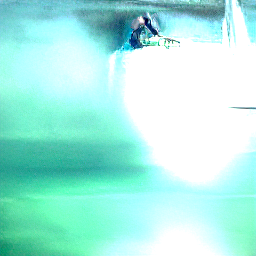

✅ All iterations completed.


In [46]:
text = 'Beautifull green forest with a lot of green trees'

generated_image = generate_image_from_text(text, transistor_model_transformer, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.95 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


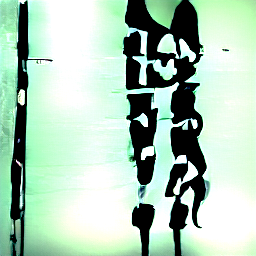

✅ All iterations completed.


In [47]:
text = 'Blue ocean with blue waves'

generated_image = generate_image_from_text(text, transistor_model_transformer, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.21 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


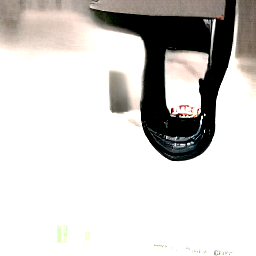

✅ All iterations completed.


In [48]:
text = 'Yellow beautiful flower'

generated_image = generate_image_from_text(text, transistor_model_transformer, vqgan_model, encode_text, config.DEVICE)

---

In [18]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Transistor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [20]:
def load_transistor_model(model_path):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = 2048
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()

    return transistor_model

# Usage
transistor_model = load_transistor_model('transistor/FNN/best_transistor_model.pth')

🕰️ Time: 15.91 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


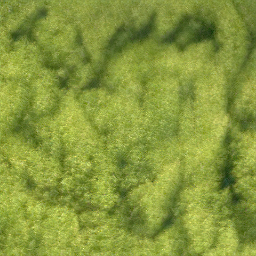

✅ All iterations completed.


In [21]:
text = 'Beautifull green forest with a lot of green trees'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.09 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


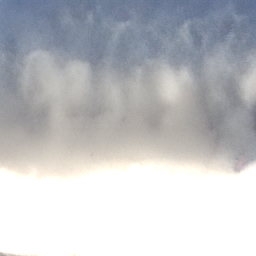

✅ All iterations completed.


In [33]:
text = 'Blue ocean with blue waves and sandy beach'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.38 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


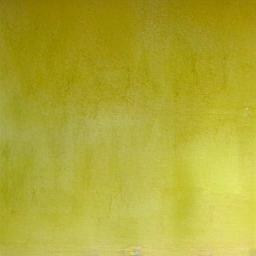

✅ All iterations completed.


In [34]:
text = 'Yellow beautiful flower'

generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

---